# Compact Convolutional Transformers (10 points)

In this task you will train Vision Transformer-like network for cifar10 images classification.

This task is based on paper [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf)

By implementing all the missing code snippets you can get 10 points. Good luck!


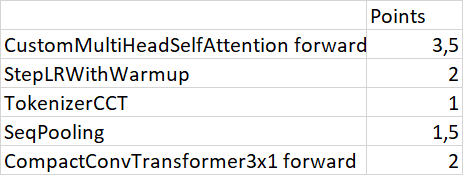

## CIFAR dataset

You have already met this dataset in seminars.

* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [ ]:
# when running in colab, un-comment this
!wget https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py

In [1]:
#!L
import numpy as np
import random
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Load data from cifar_data/cifar-10-batches-py/test_batch
(40000, 3, 32, 32) (40000,)


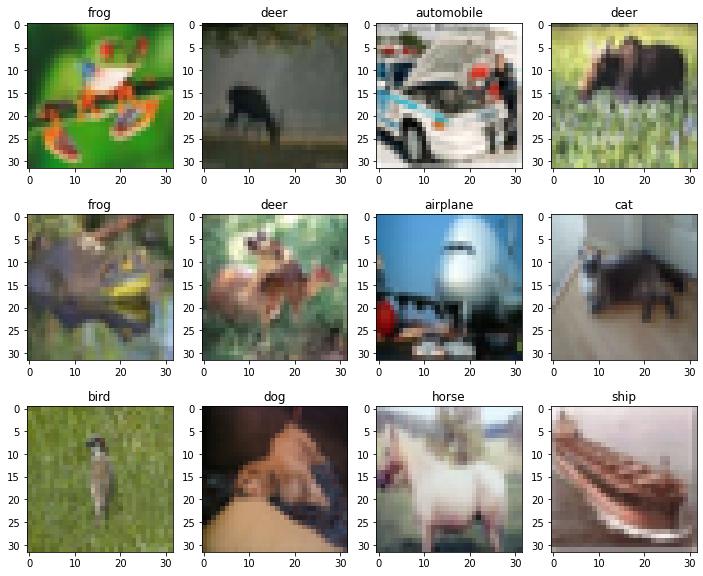

In [2]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
    plt.title(class_names[y_train[i]])

## Prepare dataset and loss

The following code is based on homework 1-pt2 and should be familiar to you.

In [3]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm

In [4]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [5]:
#!L
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean().cpu()

In [6]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2470, 0.2435, 0.2616))

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop((32,32), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [7]:
from torchvision.datasets import CIFAR10

NUM_WORKERS = 16
BATCH_SIZE = 50

train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
val_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)


## Task 1. Multi-head attention

Your turn!

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Let's implement MultiHeadAttention for beggining. It's already implemented in pytorch, so we will use `nn.MultiHeadAttention` for testing of your implementation.

As a reminder, (one-head) attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$, where $d_k$ is size of K


**Tip: read about how the torch.matmul and torch.t methods work. Think about how they will work for batches and what dimension the tensors will have.**

In [ ]:
# Complete CustomMultiHeadSelfAttention in modules.py

Let's check that your implementation works like `torch.nn.MultiheadAttention`

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
from modules import * # CustomMultiHeadSelfAttention, StepLRWithWarmup,
                        #TokenizerCCT, SeqPooling, create_mlp, DropPath, TransformerEncoder, CompactConvTransformer3x1

In [11]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)

In [12]:
custom_mha = CustomMultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias

In [13]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

for _ in range(100):
    a = torch.rand((1, 10, 128))
    out1 = mha(a, a, a)[0].cpu().detach().numpy()
    out2 = custom_mha(a).cpu().detach().numpy()
    assert np.allclose(out1, out2, atol=1e-6), f"{out1} {out2}"
    
print ("Congratulations! It works!")

Congratulations! It works!


## Task 2: Step-wise learning rate with warm-up

Your task is to implement class that works as `torch.optim.lr_scheduler.StepLR` but supports warm-up.

First of all, examine the docstring and implementation of `StepLR` scheduler:

In [28]:
torch.optim.lr_scheduler.StepLR??

Then implement `get_lr()` method. It should work as following:
1. If `self.last_epoch` is in `[0, self.warmup_epochs)`, then scheduler is in warm-up mode and learning rate should lineary increase during epochs from `self.warmup_lr_init` to `self.base_lrs` (which is the original learning rate of optimizer)
2. If `self.last_epoch` is equal to `self.warmup_epochs`, then just return `self.base_lrs`.
3. If `self.last_epoch - self.warmup_epochs` is not divisible by `self.step_size` then just return the previous learning rate which is available through `[group['lr'] for group in self.optimizer.param_groups]`
4. If `self.last_epoch - self.warmup_epochs` is divisible by `self.step_size` and the current learning rate multiplied by `self.gamma` is not less then self.min_lr, then multiply it and return the new value.
5. Otherwise just return the last learning rate

In [ ]:
# Complete class StepLRWithWarmup in modules.py

Let's check what you have written.


All asserts were passed!


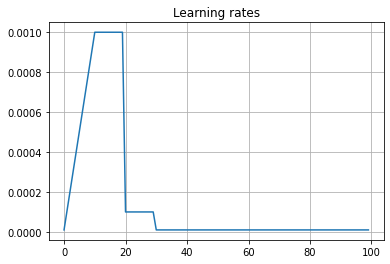

In [33]:
WARMUP_LR_INIT = 1e-5
WARMUP_EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
MIN_LR = 1e-5
OPT_LR = 1e-3

dummy_net = nn.Sequential(nn.Linear(10,10))
dummy_opt = torch.optim.Adam(dummy_net.parameters(), lr=OPT_LR)

scheduler = StepLRWithWarmup(dummy_opt, step_size=STEP_SIZE, gamma=GAMMA, 
                                      warmup_epochs=WARMUP_EPOCHS, warmup_lr_init=WARMUP_LR_INIT,
                                      min_lr=MIN_LR)

# we need to do at least one optimizer step before calling scheduler.step()
# in order to make pytorch happy
dummy_opt.step()  


learning_rates = []
for i in range(100):
    learning_rates.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(learning_rates)
plt.grid()
plt.title('Learning rates')
    
assert np.isclose(learning_rates[0], WARMUP_LR_INIT), \
    f"LR on the first epoch should be equal to {WARMUP_LR_INIT}, actual value {learning_rates[0]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS], OPT_LR), \
    f"LR after warmup shold be equal to {OPT_LR}, actual value {learning_rates[WARMUP_EPOCHS]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE-1], OPT_LR), \
    f"LR after warmup + (STEP_SIZE-1) steps should be equal to {OPT_LR}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE], OPT_LR*GAMMA), \
    f"LR after warmup + (STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1], OPT_LR*GAMMA), \
    f"LR after warmup + (2*STEP_SIZE-1) steps should be equal to {OPT_LR*GAMMA}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+2*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (2*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+2*STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+3*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (3*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+3*STEP_SIZE]}"

for i in range(WARMUP_EPOCHS):
    expected_val = WARMUP_LR_INIT + i*(OPT_LR-WARMUP_LR_INIT) / WARMUP_EPOCHS
    actual_val = learning_rates[i]
    assert np.isclose(actual_val, expected_val), \
        f"LR should linary increase from {WARMUP_LR_INIT} to {OPT_LR} during warmup."\
        f"Expected: {expected_val}, actual: {actual_val}, iteration={i}"
assert all(elem[0] >= MIN_LR for elem in learning_rates)
print("All asserts were passed!")

## Task 3. Compact Convolutional Transformer

During seminar you learned the main components of vision transformer: Tokenizer, Transformer encoder, position embeddings. At this point, it's expected that you have solved the ipython notebook from the seminar. If you didn't, then you know what to do before starting the current task)

Your task is to implement Compact Convolutional Transformer (CCT). It has two main changes comparing to the original ViT that was implemented during seminar. The first one is in tokenizer. Authors of CCT suggested to apply the first convolution with stride=1 allowing transformer to work with input patches that overlaps with each other. Since simple removing of stride increases the spatial resolution of the input tensor, we use MaxPool2d with desired stride in order to reduce the number of tokens.

In [ ]:
# Complete class TokenizerCCT in modules.py

The second change is that CCT uses learnable pooling instead of class token for global features extraction. Its formula is similar to attention formula:
$$y = \text{softmax}(WX^T+b) * X$$
where $X$ - layer input - matrix of shape [batch_size, n_tokens, n_embedding], $W$, $b$ - learnable parameters, that transform each token embedding vector to 1 element (in fact it's just a linear layer with output_dim=1).

In [ ]:
# Complete class SeqPooling in modules.py

### The following three modules were implemented by you during seminar, so you can just copy-paste their implementations.

MLP for transformer encoder is just a simple two-layer perceptron with GELU as non-linearity. It also uses Dropout after each Linear layer in order to reduce overfitting. Important thing is that size of hidden state on MLP is usually several times bigger than size of MLP input.

In [ ]:
# Complete create_mlp function in modules.py

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [ ]:
# Complete class DropPath in modules.py

In [ ]:
# Complete class TransformerEncoder in modules.py

The final class for the CCT. It looks the same as `VisionTransformer` class in seminar notebook, except the custom tokenizer and pooling. Here we implement a simple version of CCT, whose Tokenizer consist of one convolution of 3x3.

In [ ]:
# Complete class CompactConvTransformer3x1 in modules.py

## Final training 

If everything was implemented correctly, the following code will give you a model with > 84.5% accuracy (in fact it should be ~87.5%). If you see a smaller number, check your implementation of modules above.

In [35]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = CompactConvTransformer3x1(input_height=32, input_width=32, n_tokens=16, n_input_channels=3, 
                                  embedding_dim=128, num_layers=4, num_heads=4, num_classes=10, mlp_ratio=2)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = StepLRWithWarmup(opt, 40, gamma=0.3, warmup_epochs=10)

In [44]:
import time
from tqdm.notebook import tqdm_notebook
num_epochs = 120 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    val_accuracy = []
    
    for X_batch, y_batch in tqdm_notebook(train_batch_gen): # or train_batch_gen
        opt.zero_grad()
        # train on batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = compute_loss(logits, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.numpy())
    print (scheduler.get_last_lr())
    scheduler.step()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in tqdm_notebook(val_batch_gen): # or val_batch_gen
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy) * 100))

  0%|          | 0/1000 [00:00<?, ?it/s]

[1e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 120 took 67.471s
  training loss (in-iteration): 	2.177264
  validation accuracy: 			25.59 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.00010899999999999999]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 of 120 took 71.408s
  training loss (in-iteration): 	1.835485
  validation accuracy: 			41.03 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000208]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 of 120 took 70.622s
  training loss (in-iteration): 	1.615182
  validation accuracy: 			48.30 %


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5 of 120 took 69.228s
  training loss (in-iteration): 	1.353879
  validation accuracy: 			56.94 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000505]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 of 120 took 66.485s
  training loss (in-iteration): 	1.264724
  validation accuracy: 			63.30 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0006039999999999999]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 of 120 took 67.915s
  training loss (in-iteration): 	1.183147
  validation accuracy: 			63.25 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12 of 120 took 50.554s
  training loss (in-iteration): 	0.985832
  validation accuracy: 			71.28 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13 of 120 took 59.409s
  training loss (in-iteration): 	0.953936
  validation accuracy: 			70.30 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17 of 120 took 77.966s
  training loss (in-iteration): 	0.862926
  validation accuracy: 			74.25 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18 of 120 took 77.109s
  training loss (in-iteration): 	0.850340
  validation accuracy: 			74.53 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 21 of 120 took 78.185s
  training loss (in-iteration): 	0.803954
  validation accuracy: 			75.37 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 22 of 120 took 73.027s
  training loss (in-iteration): 	0.791851
  validation accuracy: 			76.57 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 23 of 120 took 49.171s
  training loss (in-iteration): 	0.783213
  validation accuracy: 			76.00 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 27 of 120 took 67.400s
  training loss (in-iteration): 	0.742197
  validation accuracy: 			76.81 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 28 of 120 took 67.516s
  training loss (in-iteration): 	0.735224
  validation accuracy: 			76.55 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 29 of 120 took 69.393s
  training loss (in-iteration): 	0.728383
  validation accuracy: 			76.92 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 30 of 120 took 67.789s
  training loss (in-iteration): 	0.720277
  validation accuracy: 			77.34 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 31 of 120 took 68.894s
  training loss (in-iteration): 	0.718370
  validation accuracy: 			78.41 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 32 of 120 took 68.510s
  training loss (in-iteration): 	0.709010
  validation accuracy: 			77.91 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 33 of 120 took 68.324s
  training loss (in-iteration): 	0.701460
  validation accuracy: 			78.29 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 35 of 120 took 67.284s
  training loss (in-iteration): 	0.692380
  validation accuracy: 			79.01 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 36 of 120 took 67.649s
  training loss (in-iteration): 	0.685781
  validation accuracy: 			76.74 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 39 of 120 took 59.525s
  training loss (in-iteration): 	0.673967
  validation accuracy: 			78.62 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 40 of 120 took 48.293s
  training loss (in-iteration): 	0.672274
  validation accuracy: 			78.77 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 42 of 120 took 68.490s
  training loss (in-iteration): 	0.663025
  validation accuracy: 			79.65 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 43 of 120 took 78.892s
  training loss (in-iteration): 	0.657194
  validation accuracy: 			78.51 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 45 of 120 took 77.798s
  training loss (in-iteration): 	0.650189
  validation accuracy: 			80.20 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 47 of 120 took 79.043s
  training loss (in-iteration): 	0.648131
  validation accuracy: 			79.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 52 of 120 took 51.292s
  training loss (in-iteration): 	0.535858
  validation accuracy: 			82.04 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 53 of 120 took 57.611s
  training loss (in-iteration): 	0.525201
  validation accuracy: 			82.53 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 55 of 120 took 68.109s
  training loss (in-iteration): 	0.512263
  validation accuracy: 			82.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 57 of 120 took 68.073s
  training loss (in-iteration): 	0.508811
  validation accuracy: 			83.21 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 58 of 120 took 68.327s
  training loss (in-iteration): 	0.500973
  validation accuracy: 			82.87 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 61 of 120 took 67.315s
  training loss (in-iteration): 	0.498703
  validation accuracy: 			83.09 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 63 of 120 took 67.797s
  training loss (in-iteration): 	0.492074
  validation accuracy: 			82.82 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 64 of 120 took 67.317s
  training loss (in-iteration): 	0.491597
  validation accuracy: 			83.41 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 68 of 120 took 50.726s
  training loss (in-iteration): 	0.482437
  validation accuracy: 			82.71 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 70 of 120 took 77.320s
  training loss (in-iteration): 	0.478041
  validation accuracy: 			83.02 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 74 of 120 took 77.708s
  training loss (in-iteration): 	0.477470
  validation accuracy: 			83.45 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 75 of 120 took 77.981s
  training loss (in-iteration): 	0.475966
  validation accuracy: 			83.57 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 77 of 120 took 77.370s
  training loss (in-iteration): 	0.475268
  validation accuracy: 			82.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 78 of 120 took 63.826s
  training loss (in-iteration): 	0.467047
  validation accuracy: 			83.69 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 79 of 120 took 50.174s
  training loss (in-iteration): 	0.468292
  validation accuracy: 			82.79 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 84 of 120 took 66.403s
  training loss (in-iteration): 	0.461606
  validation accuracy: 			83.63 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 85 of 120 took 66.639s
  training loss (in-iteration): 	0.458955
  validation accuracy: 			83.34 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 90 of 120 took 68.911s
  training loss (in-iteration): 	0.459460
  validation accuracy: 			83.31 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 91 of 120 took 66.738s
  training loss (in-iteration): 	0.422002
  validation accuracy: 			84.49 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 96 of 120 took 77.191s
  training loss (in-iteration): 	0.401151
  validation accuracy: 			84.24 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 97 of 120 took 80.137s
  training loss (in-iteration): 	0.403040
  validation accuracy: 			84.39 %


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 100 of 120 took 78.393s
  training loss (in-iteration): 	0.402460
  validation accuracy: 			84.56 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 101 of 120 took 77.187s
  training loss (in-iteration): 	0.395987
  validation accuracy: 			84.77 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 102 of 120 took 79.389s
  training loss (in-iteration): 	0.395802
  validation accuracy: 			84.65 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 103 of 120 took 78.552s
  training loss (in-iteration): 	0.394368
  validation accuracy: 			84.49 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 104 of 120 took 78.576s
  training loss (in-iteration): 	0.397813
  validation accuracy: 			84.58 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 105 of 120 took 52.091s
  training loss (in-iteration): 	0.396722
  validation accuracy: 			84.76 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 106 of 120 took 49.398s
  training loss (in-iteration): 	0.392366
  validation accuracy: 			84.51 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 107 of 120 took 68.221s
  training loss (in-iteration): 	0.392181
  validation accuracy: 			84.19 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 108 of 120 took 68.055s
  training loss (in-iteration): 	0.392473
  validation accuracy: 			84.73 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 109 of 120 took 68.303s
  training loss (in-iteration): 	0.391135
  validation accuracy: 			84.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 110 of 120 took 68.808s
  training loss (in-iteration): 	0.388202
  validation accuracy: 			84.87 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 111 of 120 took 67.497s
  training loss (in-iteration): 	0.389432
  validation accuracy: 			84.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 112 of 120 took 68.647s
  training loss (in-iteration): 	0.386906
  validation accuracy: 			84.94 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 113 of 120 took 68.064s
  training loss (in-iteration): 	0.390507
  validation accuracy: 			84.43 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 114 of 120 took 68.099s
  training loss (in-iteration): 	0.386720
  validation accuracy: 			84.65 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 115 of 120 took 68.686s
  training loss (in-iteration): 	0.391526
  validation accuracy: 			84.79 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 116 of 120 took 67.331s
  training loss (in-iteration): 	0.388639
  validation accuracy: 			84.50 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 117 of 120 took 68.761s
  training loss (in-iteration): 	0.383159
  validation accuracy: 			84.64 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 118 of 120 took 67.805s
  training loss (in-iteration): 	0.385072
  validation accuracy: 			84.53 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 119 of 120 took 69.124s
  training loss (in-iteration): 	0.388934
  validation accuracy: 			84.23 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 120 of 120 took 57.207s
  training loss (in-iteration): 	0.383685
  validation accuracy: 			84.82 %
